# Test data quality at scale with PyDeequ

This notebook contains examples of the below 5 main functions of Deequ
1. Metrics Computation
2. Constraint verification
3. Data Profiling
4. Automatic constraint suggestion
5. Metrics Repository

<img src="img\Pydeequ_components.jpg">

### Creating a Spark Session

In [5]:
from pyspark.sql import SparkSession, Row
import pydeequ

In [6]:
spark = (SparkSession
    .builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

## Loading Data

In [7]:
df = spark.read.csv('ACCOUNT_MANAGEMENT_FACT_20210122.csv',inferSchema=True,header=True)

## Metrics Computation

In [8]:
from pydeequ.analyzers import *

analysisResult = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("ACCOUNT_NBR")) \
                    .addAnalyzer(Maximum("PRIN_BALANCE_AMT")) \
                    .addAnalyzer(CountDistinct("ACCOUNT_NBR")) \
                    .addAnalyzer(Mean("PRIN_BALANCE_AMT","PRIN_BALANCE_AMT <> 0")) \
                    .addAnalyzer(Compliance("CURRENT_LOAN_TERM", "CURRENT_LOAN_TERM between 24 and 100")) \
                    .addAnalyzer(Correlation("FINANCED_AMT", "ORIG_NOTE_AMT")) \
                    .addAnalyzer(Correlation("FINANCED_AMT", "PRIN_BALANCE_AMT")) \
                    .run()
                    
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-----------+--------------------+--------------------+------------------+
|     entity|            instance|                name|             value|
+-----------+--------------------+--------------------+------------------+
|     Column|         ACCOUNT_NBR|        Completeness|               1.0|
|     Column|         ACCOUNT_NBR|       CountDistinct|           31177.0|
|     Column|    PRIN_BALANCE_AMT|             Maximum|         157631.54|
|     Column|    PRIN_BALANCE_AMT|Mean (where: PRIN...|25701.115574193544|
|    Dataset|                   *|                Size|           31177.0|
|Mutlicolumn|FINANCED_AMT,PRIN...|         Correlation|0.8645646819614178|
|     Column|   CURRENT_LOAN_TERM|          Compliance|0.9998717002918819|
|Mutlicolumn|FINANCED_AMT,ORIG...|         Correlation|               1.0|
+-----------+--------------------+--------------------+------------------+



### List of computable metrics

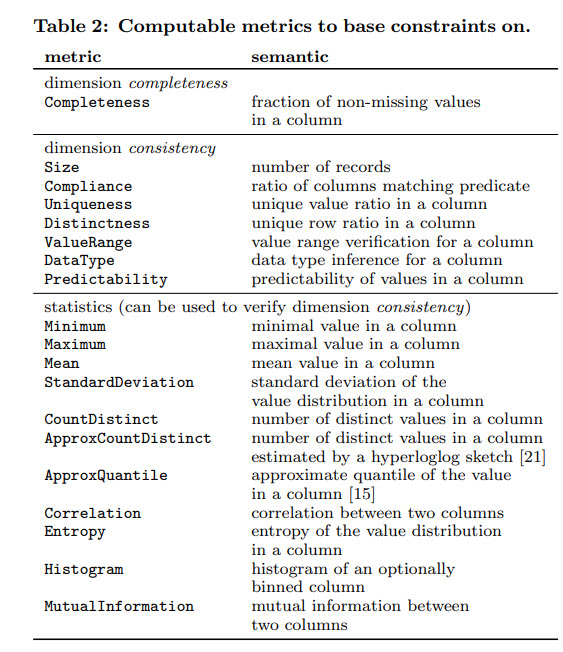

## Constraint Verification ( Data Quality tests)

After analyzing and understanding the data, we want to verify that the properties we have derived also hold for new versions of the dataset. By defining assertions on the data distribution as part of a data pipeline, we can ensure that every processed dataset is of high quality, and that any application consuming the data can rely on it.

In the below example , We are running the below tests on the 'ACCOUNT MANAGEMENT FACT' dataset from MFS EDW

In [9]:
from pydeequ.checks import *
from pydeequ.verification import *

check = Check(spark, CheckLevel.Warning, "Account Management Fact Data Quality Checks")

checkResult = VerificationSuite(spark) \
    .onData(df) \
    .addCheck(
        check.isComplete("LOAN_PRODUCT_CODE")  \
        .isUnique("ACCOUNT_NBR")  \
        .hasMaxLength("VIN", lambda x: x == 17,"WHERE VIN <> -1") \
        .isContainedIn("LOAN_PRODUCT_CODE", ["RTL", "LSE"]) \
        .satisfies("OTH_CHRG_PD_AMT_MTD < ORIG_NOTE_AMT","Business Logic validation",lambda x: x == 1.0)\
         .isNonNegative("ORIG_NOTE_AMT")) \
    .run()
    
checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult)
checkResult_df.show()

Python Callback server started!
+--------------------+-----------+------------+--------------------+-----------------+--------------------+
|               check|check_level|check_status|          constraint|constraint_status|  constraint_message|
+--------------------+-----------+------------+--------------------+-----------------+--------------------+
|Account Managemen...|    Warning|     Warning|CompletenessConst...|          Success|                    |
|Account Managemen...|    Warning|     Warning|UniquenessConstra...|          Success|                    |
|Account Managemen...|    Warning|     Warning|MaxLengthConstrai...|          Success|                    |
|Account Managemen...|    Warning|     Warning|ComplianceConstra...|          Success|                    |
|Account Managemen...|    Warning|     Warning|ComplianceConstra...|          Failure|Value: 0.99839625...|
|Account Managemen...|    Warning|     Warning|ComplianceConstra...|          Success|                  

### Constraints available for user-defined data quality checks

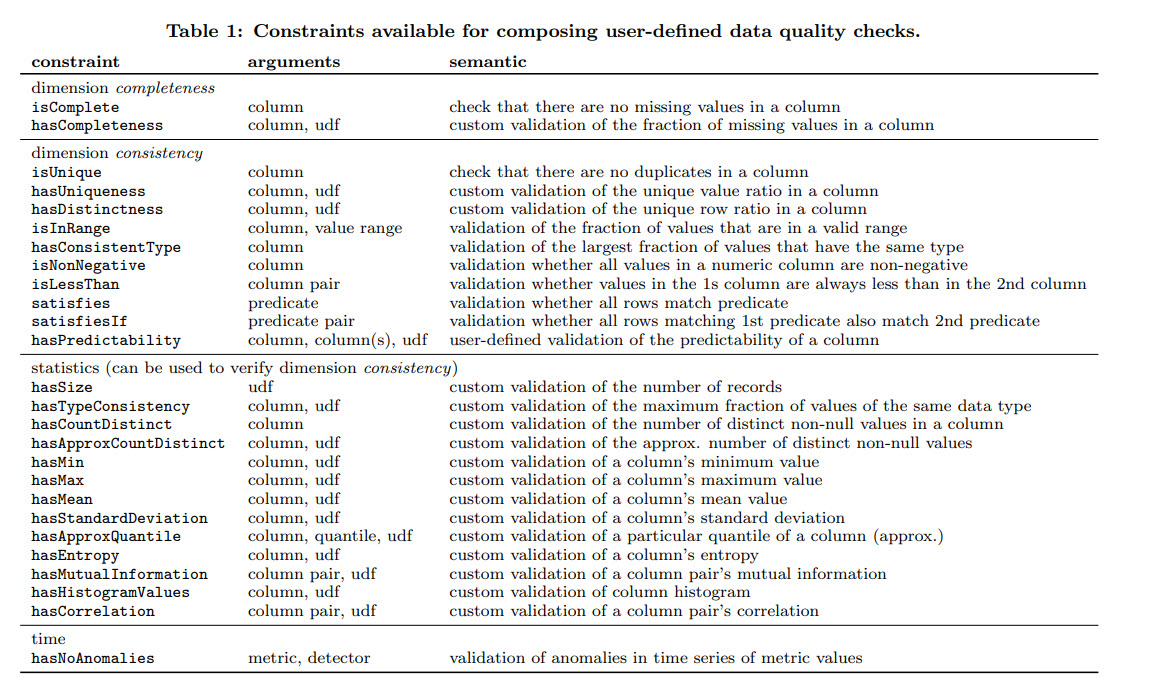

## Data Profiling

In [10]:
from pydeequ.profiles import *

result = ColumnProfilerRunner(spark) \
            .onData(df) \
            .run()

Refer https://github.com/awslabs/python-deequ/blob/master/pydeequ/profiles.py for the whole list of metrics that can be profiled for standard columns and numerical columns

In [22]:
# Printing profile information for few columns as example
for col, profile in result.profiles.items():
    if col in ("PAYMENT_PATTERN","PRIN_BALANCE_AMT","VEHICLE_MSRP","DEALER_DIM_ID"):
        print(f'Column \'{col}\'')
        print('\t',f'completeness: {profile.completeness}')
        print('\t',f'approximate number of distinct values: {profile.approximateNumDistinctValues}')
        print('\t',f'datatype: {profile.dataType}')

Column 'PAYMENT_PATTERN'
	 completeness: 0.9999358501459409
	 approximate number of distinct values: 126
	 datatype: String
Column 'VEHICLE_MSRP'
	 completeness: 1.0
	 approximate number of distinct values: 4604
	 datatype: Fractional
Column 'DEALER_DIM_ID'
	 completeness: 1.0
	 approximate number of distinct values: 597
	 datatype: Integral
Column 'PRIN_BALANCE_AMT'
	 completeness: 1.0
	 approximate number of distinct values: 28777
	 datatype: Fractional


### Extended profile for Numeric columns

In [13]:
PrinBalanceAmountProfile = result.profiles['PRIN_BALANCE_AMT']

print(f'Statistics of \'Principal Balance Amount\':')
print('\t',f"minimum: {PrinBalanceAmountProfile.minimum}")
print('\t',f"maximum: {PrinBalanceAmountProfile.maximum}")
print('\t',f"mean: {PrinBalanceAmountProfile.mean}")
print('\t',f"standard deviation: {PrinBalanceAmountProfile.stdDev}")

Statistics of 'Principal Balance Amount':
	 minimum: 0.0
	 maximum: 157631.54
	 mean: 24916.32351509125
	 standard deviation: 8817.203152256005


## Automatic Constraint Suggestion

Deequ can automatically suggest useful constraints based on the data distribution. Deequ first runs a data profiling method and then applies a set of rules on the result. Refer the link https://github.tfs.toyota.com/radhakk/Deequ-POC/blob/master/Deequ%20-%20Automatic%20Constraint%20Suggestion.ipynb to view the example for Automatic Constraint generation

## Metrics Repository - Storing Computed Metrics

In [7]:
import json
import pandas as pd

Metrics Repository allows us to store the metrics in json format on the local disk (note that it also supports HDFS and S3).

In [8]:
from pydeequ.repository import *

metrics_file = FileSystemMetricsRepository.helper_metrics_file(spark, 'metrics.json')
print(f'metrics_file path: {metrics_file}')
repository = FileSystemMetricsRepository(spark, metrics_file)

metrics_file path: C:\Users\radhakk\AppData\Local\Temp\1611594580030-0\metrics.json



Each set of metrics that we computed needs be indexed by a so-called ResultKey, which contains a timestamp and supports arbitrary tags in the form of key-value pair

In [9]:
key_tags = {'tag': 'Analysis1'}
resultKey = ResultKey(spark, ResultKey.current_milli_time(), key_tags)

In [10]:
from pydeequ.analyzers import *

analysisResult1 = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("ACCOUNT_NBR")) \
                    .addAnalyzer(Maximum("PRIN_BALANCE_AMT")) \
                    .addAnalyzer(CountDistinct("ACCOUNT_NBR")) \
                    .addAnalyzer(Mean("PRIN_BALANCE_AMT")) \
                    .addAnalyzer(Compliance("CURRENT_LOAN_TERM", "CURRENT_LOAN_TERM between 24 and 100")) \
                    .addAnalyzer(Correlation("FINANCED_AMT", "ORIG_NOTE_AMT")) \
                    .addAnalyzer(Correlation("FINANCED_AMT", "PRIN_BALANCE_AMT")) \
                    .useRepository(repository) \
                    .saveOrAppendResult(resultKey) \
                    .run()
                    
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-----------+--------------------+-------------+------------------+
|     entity|            instance|         name|             value|
+-----------+--------------------+-------------+------------------+
|     Column|         ACCOUNT_NBR| Completeness|               1.0|
|     Column|         ACCOUNT_NBR|CountDistinct|           31177.0|
|     Column|    PRIN_BALANCE_AMT|      Maximum|         157631.54|
|     Column|    PRIN_BALANCE_AMT|         Mean| 24916.32351509125|
|    Dataset|                   *|         Size|           31177.0|
|Mutlicolumn|FINANCED_AMT,PRIN...|  Correlation|0.8645646819614178|
|     Column|   CURRENT_LOAN_TERM|   Compliance|0.9998717002918819|
|Mutlicolumn|FINANCED_AMT,ORIG...|  Correlation|               1.0|
+-----------+--------------------+-------------+------------------+



Load back the analysis results into Repository

In [11]:
analysisResult_metRep = repository.load() \
                            .before(ResultKey.current_milli_time()) \
                            .getSuccessMetricsAsDataFrame()

analysisResult_metRep.show()

+-----------+--------------------+-------------+------------------+-------------+---------+
|     entity|            instance|         name|             value| dataset_date|      tag|
+-----------+--------------------+-------------+------------------+-------------+---------+
|     Column|         ACCOUNT_NBR| Completeness|               1.0|1611594746425|Analysis1|
|     Column|         ACCOUNT_NBR|CountDistinct|           31177.0|1611594746425|Analysis1|
|     Column|    PRIN_BALANCE_AMT|      Maximum|         157631.54|1611594746425|Analysis1|
|     Column|    PRIN_BALANCE_AMT|         Mean| 24916.32351509125|1611594746425|Analysis1|
|    Dataset|                   *|         Size|           31177.0|1611594746425|Analysis1|
|Mutlicolumn|FINANCED_AMT,PRIN...|  Correlation|0.8645646819614178|1611594746425|Analysis1|
|     Column|   CURRENT_LOAN_TERM|   Compliance|0.9998717002918819|1611594746425|Analysis1|
|Mutlicolumn|FINANCED_AMT,ORIG...|  Correlation|               1.0|1611594746425

Let's run another Analysis

In [12]:
key_tags_2 = {'tag': 'Analysis2'}
resultKey_2 = ResultKey(spark, ResultKey.current_milli_time(), key_tags_2)

In [17]:
analysisResult2 = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("SRVC_ACCOUNT_ID")) \
                    .addAnalyzer(Maximum("FINANCED_AMT")) \
                    .addAnalyzer(CountDistinct("SRVC_ACCOUNT_ID")) \
                    .addAnalyzer(Mean("FINANCED_AMT")) \
                    .addAnalyzer(Compliance("CURRENT_LOAN_TERM", "CURRENT_LOAN_TERM between 10 and 100")) \
                    .addAnalyzer(Correlation("FINANCED_AMT", "ORIG_NOTE_AMT")) \
                    .addAnalyzer(Correlation("ORIG_NOTE_AMT", "PRIN_BALANCE_AMT")) \
                    .useRepository(repository) \
                    .saveOrAppendResult(resultKey_2) \
                    .run()
                    
analysisResult2_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult2)
analysisResult2_df.show()

+-----------+--------------------+-------------+------------------+
|     entity|            instance|         name|             value|
+-----------+--------------------+-------------+------------------+
|     Column|        FINANCED_AMT|      Maximum|         167721.63|
|     Column|        FINANCED_AMT|         Mean|27318.502986175696|
|Mutlicolumn|ORIG_NOTE_AMT,PRI...|  Correlation|0.8645646819614178|
|     Column|   CURRENT_LOAN_TERM|   Compliance|0.9999358501459409|
|     Column|     SRVC_ACCOUNT_ID|CountDistinct|           31177.0|
|    Dataset|                   *|         Size|           31177.0|
|     Column|     SRVC_ACCOUNT_ID| Completeness|               1.0|
|Mutlicolumn|FINANCED_AMT,ORIG...|  Correlation|               1.0|
+-----------+--------------------+-------------+------------------+



In [18]:
analysisResult_metRep_2 = repository.load() \
                            .before(ResultKey.current_milli_time()) \
                            .getSuccessMetricsAsDataFrame()

analysisResult_metRep_2.show(analysisResult_metRep_2.count(), False)

+-----------+------------------------------+-------------+------------------+-------------+---------+
|entity     |instance                      |name         |value             |dataset_date |tag      |
+-----------+------------------------------+-------------+------------------+-------------+---------+
|Column     |FINANCED_AMT                  |Maximum      |167721.63         |1611594746425|Analysis1|
|Column     |FINANCED_AMT                  |Mean         |27318.502986175696|1611594746425|Analysis1|
|Column     |ACCOUNT_NBR                   |Completeness |1.0               |1611594746425|Analysis1|
|Mutlicolumn|ORIG_NOTE_AMT,PRIN_BALANCE_AMT|Correlation  |0.8645646819614178|1611594746425|Analysis1|
|Column     |CURRENT_LOAN_TERM             |Compliance   |0.9999358501459409|1611594746425|Analysis1|
|Column     |ACCOUNT_NBR                   |CountDistinct|31177.0           |1611594746425|Analysis1|
|Column     |SRVC_ACCOUNT_ID               |CountDistinct|31177.0           |16115

We can see the differences in the dataset_date and tag column and filter our results

In [19]:
filtered_tags = repository.load() \
        .withTagValues(key_tags_2) \
        .getSuccessMetricsAsDataFrame()

filtered_tags.show(filtered_tags.count(), False)

+-----------+------------------------------+-------------+------------------+-------------+---------+
|entity     |instance                      |name         |value             |dataset_date |tag      |
+-----------+------------------------------+-------------+------------------+-------------+---------+
|Column     |FINANCED_AMT                  |Maximum      |167721.63         |1611594953237|Analysis2|
|Column     |FINANCED_AMT                  |Mean         |27318.502986175696|1611594953237|Analysis2|
|Mutlicolumn|ORIG_NOTE_AMT,PRIN_BALANCE_AMT|Correlation  |0.8645646819614178|1611594953237|Analysis2|
|Column     |CURRENT_LOAN_TERM             |Compliance   |0.9999358501459409|1611594953237|Analysis2|
|Column     |SRVC_ACCOUNT_ID               |CountDistinct|31177.0           |1611594953237|Analysis2|
|Dataset    |*                             |Size         |31177.0           |1611594953237|Analysis2|
|Column     |SRVC_ACCOUNT_ID               |Completeness |1.0               |16115

## Limitations

1. Deequ library won't support Spark 3.0 and above as of now . Please refer https://github.com/awslabs/deequ/issues/283
2. There is no option in deequ library to write back the anomaly records into file / database. Need to customize to make this happen

## Next Steps

1. Analyse if there is any workaround to make Deequ compatible with Spark 3.0
2. Analyse further regarding how the metrics and exception records can be stored in database
3. Check the options to create dashboards based on DQ results stored